![image](https://media.cnn.com/api/v1/images/stellar/prod/230104173032-02-chess-stock.jpg?c=16x9&q=h_653,w_1160,c_fill/f_webp)

This script showcases the process of training an AI model to play chess using a combination of data preprocessing and sequence-to-sequence learning techniques. The key steps include:

Data Preparation: Chess game data is collected and cleaned, with moves applied to FEN positions, and the dataset is formatted for training.

Tokenization and Preprocessing: The FEN positions and corresponding moves are tokenized using a transformer-based model, and the data is preprocessed for model input.

Model Training: A sequence-to-sequence model is initialized and trained on the preprocessed chess data to predict optimal moves given board positions.

By leveraging sophisticated deep learning techniques and extensive chess data, this script enables the development of an AI capable of playing chess at a high level. With further refinement and training, the AI could potentially compete against human players or provide valuable insights into chess strategies and tactics.

# TensorFlow import and TPU initialization

This section initializes TensorFlow and configures it to use TPUs for distributed training.



In [1]:
import tensorflow as tf
# Initialize TPU cluster resolver
resolver = tf.distribute.cluster_resolver.TPUClusterResolver()  

# Connect to the TPU cluster
tf.config.experimental_connect_to_cluster(resolver) 

# Initialize TPU system
tf.tpu.experimental.initialize_tpu_system(resolver) 

# Print all TPU devices available
print("All devices: ", tf.config.list_logical_devices('TPU')) 

# Create a strategy for distributing computation across TPUs
strategy = tf.distribute.TPUStrategy(resolver)  


INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.
INFO:tensorflow:Initializing the TPU system: local


2024-03-14 15:27:58.743622: E external/local_xla/xla/stream_executor/stream_executor_internal.h:177] SetPriority unimplemented for this stream.
2024-03-14 15:27:58.743730: E external/local_xla/xla/stream_executor/stream_executor_internal.h:177] SetPriority unimplemented for this stream.
2024-03-14 15:27:58.743810: E external/local_xla/xla/stream_executor/stream_executor_internal.h:177] SetPriority unimplemented for this stream.
2024-03-14 15:27:58.743885: E external/local_xla/xla/stream_executor/stream_executor_internal.h:177] SetPriority unimplemented for this stream.
2024-03-14 15:27:58.743958: E external/local_xla/xla/stream_executor/stream_executor_internal.h:177] SetPriority unimplemented for this stream.
2024-03-14 15:27:58.744156: E external/local_xla/xla/stream_executor/stream_executor_internal.h:177] SetPriority unimplemented for this stream.
2024-03-14 15:27:58.744283: E external/local_xla/xla/stream_executor/stream_executor_internal.h:177] SetPriority unimplemented for this 

INFO:tensorflow:Finished initializing TPU system.
All devices:  [LogicalDevice(name='/device:TPU:0', device_type='TPU'), LogicalDevice(name='/device:TPU:1', device_type='TPU'), LogicalDevice(name='/device:TPU:2', device_type='TPU'), LogicalDevice(name='/device:TPU:3', device_type='TPU'), LogicalDevice(name='/device:TPU:4', device_type='TPU'), LogicalDevice(name='/device:TPU:5', device_type='TPU'), LogicalDevice(name='/device:TPU:6', device_type='TPU'), LogicalDevice(name='/device:TPU:7', device_type='TPU')]
INFO:tensorflow:Found TPU system:
INFO:tensorflow:*** Num TPU Cores: 8
INFO:tensorflow:*** Num TPU Workers: 1
INFO:tensorflow:*** Num TPU Cores Per Worker: 8
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:0, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:1, T

# Installation of required packages


These lines install necessary packages using pip.

In [2]:
!pip install chess  # Install the 'chess' package for chess-related functionalities
!pip install datasets  # Install the 'datasets' package for handling datasets



[notice] A new release of pip is available: 23.0.1 -> 24.0
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.0.1 -> 24.0
[notice] To update, run: pip install --upgrade pip


# Read data from CSV
Here, the script reads data from a CSV file containing chess tactic evaluations.

In [3]:
#import pandas library
import pandas as pd

# Read data from CSV file
Data = pd.read_csv("/kaggle/input/chess-data/tactic_evals.csv")  

# Data cleaning
Clean data by dropping rows with null values

In [4]:
 # Drop the 'Evaluation' column due we will not use the evaluation principle in our model
Data.drop("Evaluation", axis=1, inplace=True) 

# Identify rows with null values
rows_with_null = Data[Data.isnull().any(axis=1)]  

# Drop rows with null values
Data_cleaned = Data.dropna()  

# Import required libraries
This section imports necessary libraries for chess-related operations and progress tracking.

In [5]:
import chess
from tqdm import tqdm

# Function to apply move to FEN position
This function applies a chess move to a given FEN position and returns the resulting FEN.


In [6]:
def apply_move(fen, move):
    # Initialize a chess board
    board = chess.Board(fen)  
    
    # Apply a move to the board
    board.push(chess.Move.from_uci(move))  
    
    # Return the resulting FEN position
    return board.fen()  


# Apply moves to FEN positions
Here, moves are applied to FEN positions using the apply_move function, and progress is tracked.

In [7]:
# Use tqdm's progress_apply method for progress tracking
tqdm.pandas()  
Data_cleaned["New FEN"] = Data_cleaned.progress_apply(lambda row: apply_move(row["FEN"], row["Move"]), axis=1)


100%|██████████| 2544451/2544451 [06:54<00:00, 6139.80it/s]
/tmp/ipykernel_2094/3181601287.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Data_cleaned["New FEN"] = Data_cleaned.progress_apply(lambda row: apply_move(row["FEN"], row["Move"]), axis=1)


# Handling null values
This part handles null values by creating a 'New FEN' column for rows with nulls and dropping the 'Move' column.

In [8]:
# Create a 'New FEN' column with FEN values for rows with nulls
rows_with_null["New FEN"] = rows_with_null["FEN"]  

# Drop the 'Move' column from rows with nulls
rows_with_null.drop('Move', axis=1, inplace=True)  

/tmp/ipykernel_2094/2104568361.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rows_with_null["New FEN"] = rows_with_null["FEN"]
/tmp/ipykernel_2094/2104568361.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rows_with_null.drop('Move', axis=1, inplace=True)


# Cleaned Data manipulation
These lines perform manipulation on the cleaned data by dropping unnecessary columns and duplicate rows.

In [9]:
# Drop the 'Move' column from cleaned data
Data_cleaned.drop('Move', axis=1, inplace=True)  

# Drop duplicate rows from cleaned data
Data_cleaned.drop_duplicates(inplace=True) 

# Drop duplicate rows from rows with null values
rows_with_null.drop_duplicates(inplace=True)  


/tmp/ipykernel_2094/690056393.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Data_cleaned.drop('Move', axis=1, inplace=True)
/tmp/ipykernel_2094/690056393.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Data_cleaned.drop_duplicates(inplace=True)
/tmp/ipykernel_2094/690056393.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rows_with_null.drop_duplicates(inplace=True)


In [10]:
# Concatenate cleaned and rows with null data
df = pd.concat([Data_cleaned, rows_with_null]) 

# Splitting and converting FEN and New FEN columns
These lines split the FEN and New FEN columns into two parts and store them separately.

In [11]:
# Split FEN to extract first part
df["FEN_info_1"] = df["FEN"].apply(lambda x: x.split()[0])  

 # Split FEN to extract second part
df["FEN_info_2"] = df["FEN"].apply(lambda x: ' '.join(x.split()[1:])) 

 # Drop the original FEN column
df.drop("FEN", axis=1, inplace=True) 

# Split New FEN to extract first part
df["New_FEN_1"] = df["New FEN"].apply(lambda x: x.split()[0])

# Split New FEN to extract second part
df["New_FEN_2"] = df["New FEN"].apply(lambda x: ' '.join(x.split()[1:])) 

# Drop the original New FEN column
df.drop("New FEN", axis=1, inplace=True)  


In [12]:
# Conversion functions for FEN and New FEN columns
#These functions convert numeric parts of FEN and New FEN strings into corresponding letters.
#Because tokenization does not deal with numbers, each number from each part has a meaning, 
#so I divided the FENs into parts in order to give numbers in  each part a meaning 
#so that the model can learn the meanings of the different numbers.

def convert_fen_num(x):
    num_to_letter = {'1': 'a', '2': 'c', '3': 'd', '4': 'e', '5': 'f', '6': 'g', '7': 'h', '8': 'i'}
    return ''.join(num_to_letter.get(char, char) for char in x)

def convert_info_num(x):
    info_num, move_num = x[:len(x)-2], x[len(x)-2:]

    num_mapping = {
        "q": "j", "Q": "l", "k": "m", "Q": "o", "0": "s",
        "1": "u", "2": "v", "3": "x", "4": "y", "4": "z",
        "5": "A", "6": "C", "7": "D", "8": "E", "9": "F"}

    info_num = ''.join(num_mapping.get(char, char) for char in info_num)

    move_mapping = {
        "1": "G", "2": "H", "3": "I", "4": "J", "5": "L",
        "6": "M", "7": "O", "8": "S", "9": "T"}

    move_num = ''.join(move_mapping.get(char, char) for char in move_num)

    text = info_num + move_num
    return text


# Applying conversion functions
These lines apply the conversion functions to the respective columns.

In [13]:
# Convert numeric part of FEN 1
df["FEN_info_1"] = df["FEN_info_1"].apply(lambda x: convert_fen_num(x))

# Convert numeric part of FEN 2
df["FEN_info_2"] = df["FEN_info_2"].apply(lambda x: convert_info_num(x))

# Convert numeric part of New FEN 1
df["New_FEN_1"] = df["New_FEN_1"].apply(lambda x: convert_fen_num(x))  

# Convert numeric part of New FEN 2
df["New_FEN_2"] = df['New_FEN_2'].apply(lambda x: convert_info_num(x))  


# Concatenating columns after conversion 
This section concatenates the FEN and New FEN parts into complete FEN strings.

In [14]:
# Concatenate FEN parts
df["FEN"] = df.apply(lambda row: row["FEN_info_1"] + ' ' + row["FEN_info_2"], axis=1)

# Concatenate New FEN parts
df["New_FEN"] = df.apply(lambda row: row["New_FEN_1"] + ' ' + row["New_FEN_2"], axis=1)  

 # Drop columns
df.drop(["FEN_info_1", "FEN_info_2",'New_FEN_1','New_FEN_2'], axis=1, inplace=True) 

# Joining and formatting FEN and New FEN columns
#In order to tokenization each letter individually

In [15]:
 # Join FEN parts into strings
df["FEN"] = df["FEN"].apply(lambda x: " ".join(x)) 

# Join New FEN parts into strings
df["New_FEN"] = df["New_FEN"].apply(lambda x: " ".join(x))  


In [16]:
# Importing required libraries
from datasets import Dataset

# Create a dataset from FEN and New FEN
dataset = Dataset.from_dict({"X": df["FEN"], "target": df["New_FEN"]})  

from transformers import AutoTokenizer
# Initialize tokenizer
tokenizer = AutoTokenizer.from_pretrained("google/flan-t5-small")  


# Preprocessing function
This function preprocesses the data by tokenizing input FEN and target New FEN strings.

In [17]:
def preprocess_function(examples):
    model_inputs = tokenizer(
        examples["X"],  # Input FEN
        text_target=examples["target"],  # Target New FEN
        truncation=True,  # Truncate sequences if they exceed the maximum length
        padding='max_length',  # Pad sequences to the maximum length
        max_length=70  # Set maximum sequence length
    )
    return model_inputs

In [18]:
# Applying preprocessing function to dataset
tokenized_dataset = dataset.map(preprocess_function, batched=True, batch_size=10000)

# Splitting dataset into train and test sets
tokenized_dataset = tokenized_dataset.train_test_split(0.2)

Map:   0%|          | 0/2628219 [00:00<?, ? examples/s]

# Importing required libraries for model training
These lines import necessary libraries, set a random seed, initialize an optimizer, and compile the model.

In [19]:
from transformers import TFAutoModelForSeq2SeqLM
from transformers import AdamWeightDecay

# Setting seed and initializing optimizer
tf.random.set_seed(42)  # Set random seed for reproducibility
with strategy.scope():  # Use the specified strategy for distributed training
    optimizer = AdamWeightDecay(learning_rate=2e-5, weight_decay_rate=0.01)  # Initialize optimizer
    model = TFAutoModelForSeq2SeqLM.from_pretrained("google/flan-t5-small")  # Load pre-trained model
    model.compile(optimizer=optimizer, metrics=["accuracy"])  # Compile the model with optimizer and metrics


I0000 00:00:1710430993.783697    2094 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
2024-03-14 15:43:14.239784: E external/local_xla/xla/stream_executor/stream_executor_internal.h:177] SetPriority unimplemented for this stream.
2024-03-14 15:43:14.239914: E external/local_xla/xla/stream_executor/stream_executor_internal.h:177] SetPriority unimplemented for this stream.
/usr/local/lib/python3.10/site-packages/tf_keras/src/initializers/initializers.py:121: UserWarning: The initializer RandomNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(
All PyTorch model weights were used when initializing TFT5ForConditionalGeneration.

All the weights of TFT5ForConditionalGeneration were initialized from the

# Preparing TensorFlow datasets for training and testing


In [20]:
tf_train_set = model.prepare_tf_dataset(
    tokenized_dataset["train"],  # Training data
    shuffle=True,  # Shuffle the data
    batch_size=512,  # Set batch size
).cache()  # Cache the dataset for faster access

tf_test_set = model.prepare_tf_dataset(
    tokenized_dataset["test"],  # Test data
    shuffle=False,  # Do not shuffle the data
    batch_size=512,  # Set batch size
).cache()  # Cache the dataset for faster access


In [22]:
# Training the model
model.fit(x=tf_train_set, validation_data=tf_test_set, epochs=20)  # Train the model with training and validation data

Epoch 1/20
4106/4106 [==============================] - 675s 164ms/step - loss: 0.0851 - accuracy: 0.9756 - val_loss: 0.0711 - val_accuracy: 0.9790
Epoch 2/20
4106/4106 [==============================] - 671s 163ms/step - loss: 0.0813 - accuracy: 0.9765 - val_loss: 0.0689 - val_accuracy: 0.9795
Epoch 3/20
4106/4106 [==============================] - 678s 165ms/step - loss: 0.0785 - accuracy: 0.9771 - val_loss: 0.0673 - val_accuracy: 0.9798
Epoch 4/20
4106/4106 [==============================] - 683s 166ms/step - loss: 0.0762 - accuracy: 0.9777 - val_loss: 0.0660 - val_accuracy: 0.9801
Epoch 5/20
4106/4106 [==============================] - 685s 167ms/step - loss: 0.0744 - accuracy: 0.9781 - val_loss: 0.0648 - val_accuracy: 0.9803
Epoch 6/20
4106/4106 [==============================] - 684s 167ms/step - loss: 0.0728 - accuracy: 0.9784 - val_loss: 0.0638 - val_accuracy: 0.9805
Epoch 7/20
4106/4106 [==============================] - 684s 167ms/step - loss: 0.0715 - accuracy: 0.9787 - val_

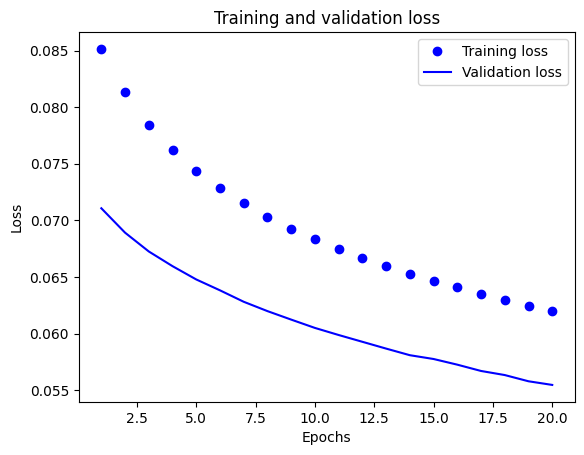

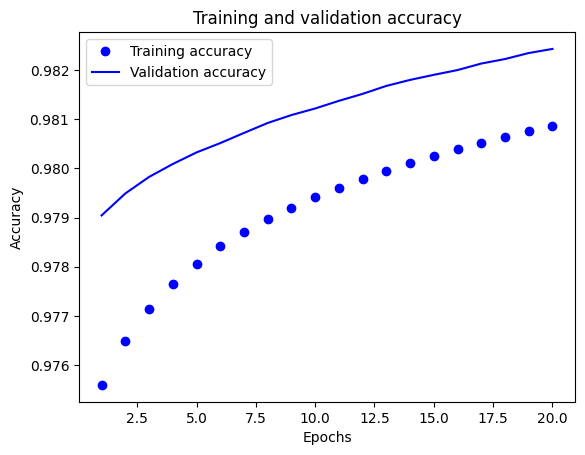

In [23]:
import matplotlib.pyplot as plt

# Extracting the values
loss = model.history.history['loss']
val_loss = model.history.history['val_loss']
accuracy = model.history.history['accuracy']
val_accuracy = model.history.history['val_accuracy']
epochs = range(1, len(loss) + 1)

# Plotting the loss
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plotting the accuracy
plt.plot(epochs, accuracy, 'bo', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


# the accuracy is high and continues to improve, and the model learns perfectly, but due to the cost of significant time and effort, I will stop here